In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import statsmodels.api as sm

In [3]:
### Input expression data

gene_expr = pd.read_table("../data/GXEpaper/GeneCounts/VOOMCounts_CPM1_head_hsctrl_covfree_4svs_CORRECT_Jan8.21.txt")

In [4]:
### Input covariates

covariates = pd.read_table("../data/GXEpaper/Covariates_forGEMMA_Jan82021.txt", sep = ",")

In [5]:
ID_C = covariates.query('treatment == 1')["ID"]
ID_HS = covariates.query('treatment == 1')["ID"]

In [6]:
gene_expr_dict = {"C": gene_expr[ID_C].T, "HS": gene_expr[ID_HS].T}

In [7]:
gene_expr_corr = {"C": np.array(gene_expr_dict["C"].corr()), 
                  "HS": np.array(gene_expr_dict["HS"].corr())}

In [8]:
g = Graph(directed=False)
n_genes = 100 #gene_expr_corr["C"].shape[1]
g.add_vertex(n = n_genes)


<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7fc3b7671430>

In [29]:
q = g.new_ep("double", 0)
for i in range(n_genes):
    for j in range(i):
        X = np.array(gene_expr_dict["C"][i]).reshape(-1, 1)
        X = sm.add_constant(X)
        y = np.array(gene_expr_dict["C"][j]).reshape(-1, 1)
        results = sm.OLS(y, X).fit()
        pvalue = results.pvalues[1]
        if((pvalue < 1e-3) & (gene_expr_corr["C"][i, j] > 0.05)):
            g.add_edge(i, j)
            e = g.edge(i, j)
            q[e] = gene_expr_corr["C"][i, j]

In [30]:
q.a  =q.a / max(q.a) * 10

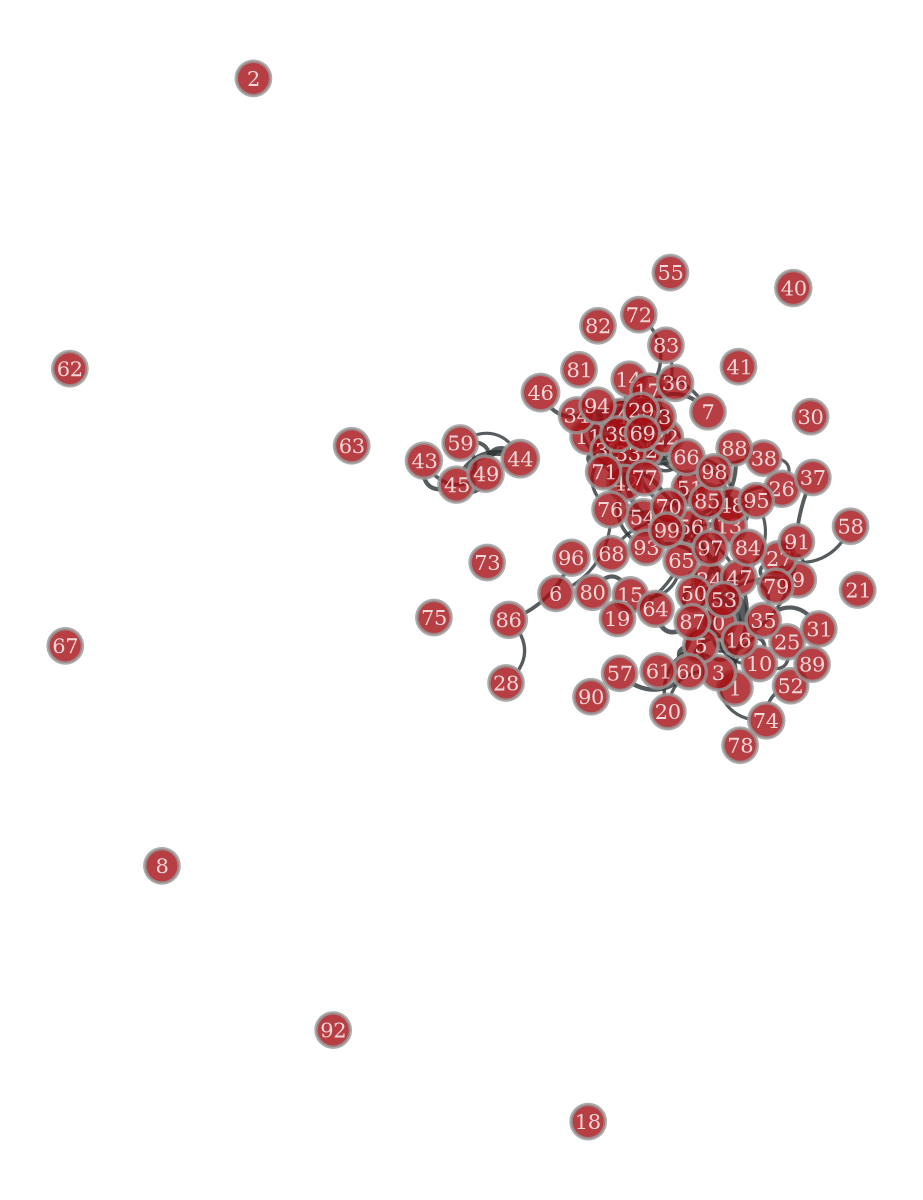

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc3b76afe20, at 0x7fc3b75ade20>

In [31]:
graph_draw(g, vertex_text=g.vertex_index, edge_pen_width=q)

In [32]:
N = g.num_vertices()
E = g.num_edges()
[N, E, ((N * (N - 1))/2 - E)]

[100, 1253, 3697.0]

In [33]:
# We inititialize UncertainBlockState, assuming that each non-edge
# has an uncertainty of q_default, chosen to preserve the expected
# density of the original network:

q_default = (E - q.a.sum()) / ((N * (N - 1))/2 - E)
q_default

PropertyArray(0.22666237)

In [34]:
state = UncertainBlockState(g, q=q, q_default=q_default)
mcmc_equilibrate(state, wait=100, mcmc_args=dict(niter=10))

/home/diogro/projects/NEX-HS_C-GxE/graphtool/.venv/lib/python3.9/site-packages/graph_tool/inference/uncertain_blockmodel.py:402: RuntimeWarning: divide by zero encountered in log
  self.q = self.g.new_ep("double", vals=log(q.fa) - log1p(-q.fa))
/home/diogro/projects/NEX-HS_C-GxE/graphtool/.venv/lib/python3.9/site-packages/graph_tool/inference/uncertain_blockmodel.py:402: RuntimeWarning: invalid value encountered in log1p
  self.q = self.g.new_ep("double", vals=log(q.fa) - log1p(-q.fa))


(nan, 366355, 59598)

In [35]:
u = None              # marginal posterior edge probabilities
bs = []               # partitions
cs = []               # average local clustering coefficient

def collect_marginals(s):
   global bs, u, cs
   u = s.collect_marginal(u)
   bstate = s.get_block_state()
   bs.append(bstate.levels[0].b.a.copy())
   cs.append(local_clustering(s.get_graph()).fa.mean())

mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                 callback=collect_marginals)

eprob = u.ep.eprob

In [37]:
u = GraphView(u, efilt=u.ep.eprob.fa > .5)

In [38]:
bstate = state.get_block_state()
bstate = bstate.levels[0].copy(g=u)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, converge=True)
pv = pmode.get_marginal(u)

In [39]:
bstate.draw(vertex_text=u.vertex_index,
            output="100genes-uncertain-reconstruction-marginals.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc3b75c19d0, at 0x7fc3b2f64970>